# <center> Tweet Sentiment Analysis  </center> <br> 

### Estimation of the emotion of a tweet based on words of the tweet text and using an LSTM

### The dataset consists of 40,000 tweets with sentiments. 
### The sentiment is one of five (5) classes. The dataset features are:
- Tweet ID (ignore)
- Sentiment (categorical): tweet sentiment (target)
- Author (ignore)
- Content (string): text content of the tweet

License: Public domain (CC0)

Data: https://data.world/crowdflower/sentiment-analysis-in-text

In [1]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import re

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import regularizers

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Dropout, BatchNormalization
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords 
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from livelossplot import PlotLossesKeras
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("text_emotion.csv")
df.head(5)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


# Get max tweet length

In [4]:
max_tweet_length= df["content"].str.len().max()
print(max_tweet_length)

167


# Get number of classes

In [5]:
classes = np.unique(df["sentiment"])
nr_classes = len(classes)
print(classes)
print(nr_classes)

['anger' 'boredom' 'empty' 'enthusiasm' 'fun' 'happiness' 'hate' 'love'
 'neutral' 'relief' 'sadness' 'surprise' 'worry']
13


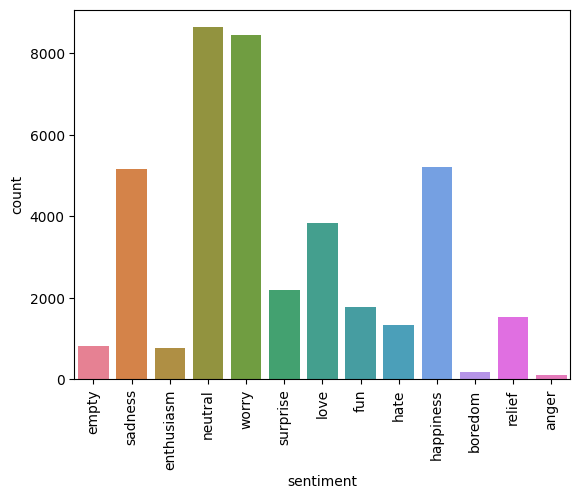

In [6]:
sns.countplot(x ='sentiment', data = df, hue='sentiment')
plt.xticks(rotation = 90);

# Explore tweets' contents

In [7]:
idx = 0
print(df['content'][idx])
print(df['sentiment'][idx])

@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[
empty


# Extract adjectives, nouns and verbs from tweets

In [8]:
stop_words = stopwords.words('english')

def filter_txt(txt_str):
    
    filtered_sentence = txt_str.replace("<br />","")
    filtered_sentence = txt_str.replace("'ll","")
    filtered_sentence = txt_str.replace("'","")

    # Keep only adjectives
    word_tokens = text_to_word_sequence(filtered_sentence)
    filtered_sentence = [w for w,tag in nltk.pos_tag(word_tokens) if ((tag[0] in "JJ")) and (len(w)>2) and (w not in stop_words)]
    #filtered_sentence = [w for w,tag in nltk.pos_tag(word_tokens) if ((tag[0] in "JJ") or (tag[0] in "NN") or (tag[0] in "VB")) and (len(w)>2) and (w not in stop_words)]
    filtered_sentence = ''.join(str(x)+' ' for x in filtered_sentence)
    #print(txt_str)
    #print(filtered_sentence)
    
    return filtered_sentence

In [9]:
idx = 3
print(df['content'][idx])
print(filter_txt(df['content'][idx]))
print(df['sentiment'][idx])

wants to hang out with friends SOON!

enthusiasm


In [10]:
df['content'] = df['content'].apply(filter_txt)

# Generate a vocabulary from all tweets

In [11]:
# Create a list with all tweets
tweets_ls = df[['content']].to_string(header=False,
                  index=False,
                  index_names=False).split(' \n')

print("Nr, of Tweets; ", np.shape(tweets_ls))

# Split each word in the tweets, thus generating a list of lists
tweets_words_ls = [w.split() for w in tweets_ls]

# Unravel or flatten the list of lists
def flatten_comprehension(list_of_lists):
    return [word for words_list in list_of_lists for word in words_list]
flattened_tweets_words = flatten_comprehension(tweets_words_ls)

Nr, of Tweets;  (40000,)


In [12]:
print("Total Nr. Words:", np.shape(flattened_tweets_words))
print("Vocabulary Size:", len(np.unique(flattened_tweets_words)))


Total Nr. Words: (45932,)
Vocabulary Size: 8824


In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(flattened_tweets_words)
tokens = tokenizer.word_index

In [14]:
print(len(np.unique(flattened_tweets_words)))
print(len(tokenizer.word_index))

8824
8824


# Get the Vocabulary Size

In [15]:
vocabulary_size = len(tokenizer.word_index)
print(vocabulary_size)

8824


# Build sequences of tokens

In [16]:
# Verify max_tweet_length
max_tweet_length_2 = max([len(tweet_txt) for tweet_txt in tweets_ls])
print(max_tweet_length)
print(max_tweet_length_2)

167
55


In [17]:
# build subsequences of different sizes, starting from 1 to the size of the sequence. 
sequences = tokenizer.texts_to_sequences(tweets_ls)
sequences = pad_sequences(sequences, maxlen=max_tweet_length, padding='pre')

In [18]:
print(sequences.shape)
print(sequences[0])

(40000, 167)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]


# Build Input and Output
#### The input to the network is all the words of the sequence except the last one, and the output is the last word of the sequence.
#### Then, convert output into categorical data using the to_categorical() method from the keras.utils module.

In [19]:
nr_classes

13

In [20]:
X = sequences
y = df[["sentiment"]].to_numpy().ravel()
y = LabelEncoder().fit_transform(y)
print(np.unique(y))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [21]:
print(X.shape)
print(y.shape)

(40000, 167)
(40000,)


In [22]:
X[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7])

In [23]:
y[0]

2

# Build training, validationand test sets

In [24]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=0)

In [25]:
print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

print(X_test.shape)
print(y_test.shape)

(25600, 167)
(25600,)
(6400, 167)
(6400,)
(8000, 167)
(8000,)


# Train an ANN to perform NLP

In [26]:
model=Sequential()
model.add(Embedding(input_dim=vocabulary_size+1, output_dim=max_tweet_length,input_length=max_tweet_length))

model.add(LSTM(50, kernel_regularizer=regularizers.L1(0.1),recurrent_regularizer=regularizers.L1(0.1)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# # Hidden layer
# model.add(Dense(units=100, 
#                 activation='relu', 
#                 kernel_initializer='uniform', 
#                 kernel_regularizer=regularizers.L2(1e-2), 
#                 bias_regularizer=regularizers.L2(1e-2), 
#                 activity_regularizer=regularizers.L2(1e-2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(units=nr_classes, activation='softmax'))

In [27]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 167, 167)          1473775   
                                                                 
 lstm (LSTM)                 (None, 50)                43600     
                                                                 
 batch_normalization (Batch  (None, 50)                200       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 13)                663       
                                                                 
Total params: 1518238 (5.79 MB)
Trainable params: 1518138 (5.79 MB)
Non-trainable params: 100 (400.00 Byte)
______________

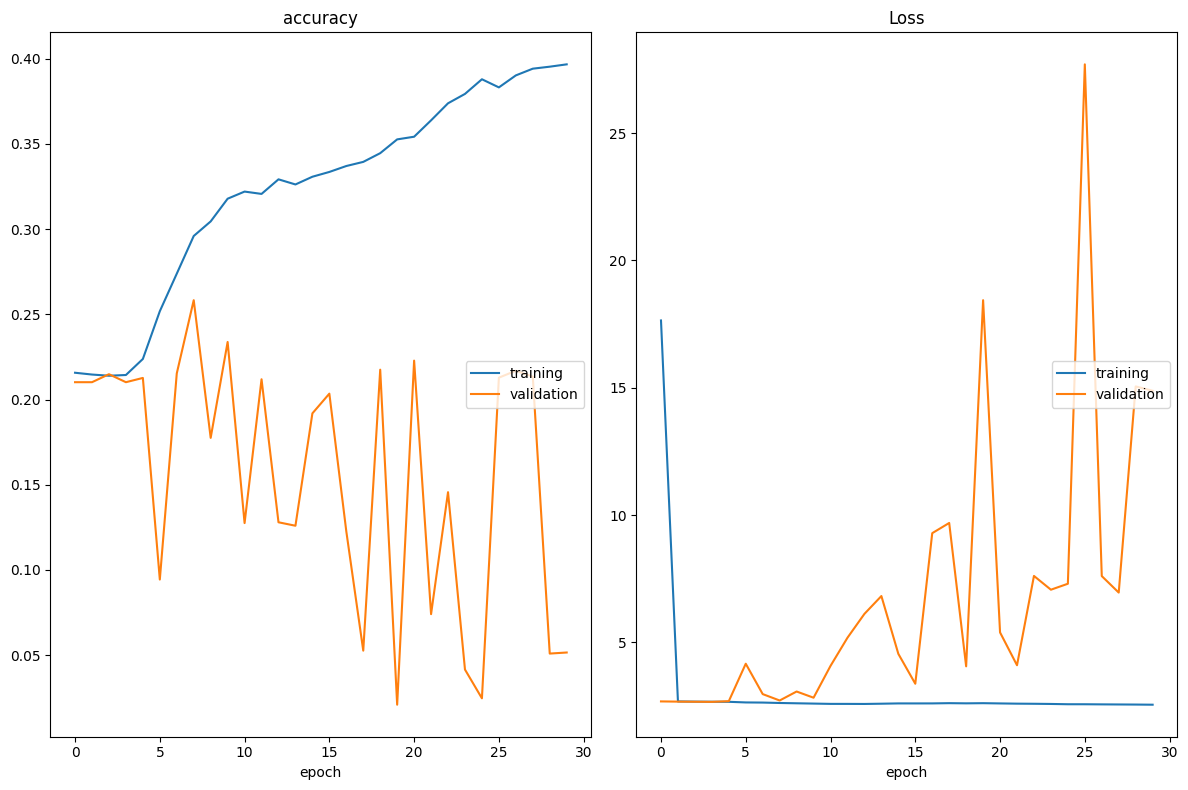

accuracy
	training         	 (min:    0.214, max:    0.397, cur:    0.397)
	validation       	 (min:    0.021, max:    0.258, cur:    0.052)
Loss
	training         	 (min:    2.547, max:   17.644, cur:    2.547)
	validation       	 (min:    2.659, max:   27.707, cur:   14.882)
800/800 [==============================] - 44s 55ms/step - loss: 2.5473 - accuracy: 0.3966 - val_loss: 14.8816 - val_accuracy: 0.0516
Epoch 31/100
166/800 [=====>........................] - ETA: 30s - loss: 2.5449 - accuracy: 0.3985

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=100, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[PlotLossesKeras()],
                    verbose=1)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluate model

In [ ]:
model.evaluate(X_test, y_test)